# Transaction Anomaly Detection
Transaction Anomaly Detection using unsupervised learning methods is a technique used to identify unusual or suspicious patterns in financial transactions without requiring labeled data for training. Since anomalies are often rare and unpredictable, unsupervised learning is particularly useful when normal and fraudulent transactions aren't clearly categorized.
## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

## 1. Data Exploration & Preprocessing
### 1.1. Examine the data

In [2]:
# Load the dataset
df = pd.read_csv('bank_transactions_data_2.csv')

# Check the shape of the dataset (rows, columns)
print("Shape of the dataset:", df.shape)

# Get dataset information (column names, non-null counts, data types)
print("Dataset Info:\n")
df.info()

# List all columns (features)
print("Columns in the dataset:", df.columns)

# Check data types of each column
print("Data types:\n", df.dtypes)

# Display first 5 rows
print("\nFirst 5 rows:\n", df.head())

Shape of the dataset: (2512, 16)
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 

### 1.1.1. Summarize Numerical Features
For numerical features, we calculate descriptive statistics.

In [3]:
# Summary statistics for numerical columns
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
        TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
count        2512.000000  2512.000000          2512.000000    2512.000000   
mean          297.593778    44.673965           119.643312       1.124602   
std           291.946243    17.792198            69.963757       0.602662   
min             0.260000    18.000000            10.000000       1.000000   
25%            81.885000    27.000000            63.000000       1.000000   
50%           211.140000    45.000000           112.500000       1.000000   
75%           414.527500    59.000000           161.000000       1.000000   
max          1919.110000    80.000000           300.000000       5.000000   

       AccountBalance  
count     2512.000000  
mean      5114.302966  
std       3900.942499  
min        101.250000  
25%       1504.370000  
50%       4735.510000  
75%       7678.820000  
max      14977.990000  


### 1.1.2. Summarize Categorical Features
For categorical features, we check unique values and their frequencies.

In [5]:
# Summary of categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Unique values in {col}:\n", df[col].value_counts())
    print("\n")

Unique values in TransactionID:
 TransactionID
TX002496    1
TX002495    1
TX002494    1
TX002493    1
TX002492    1
           ..
TX000005    1
TX000004    1
TX000003    1
TX000002    1
TX000001    1
Name: count, Length: 2512, dtype: int64


Unique values in AccountID:
 AccountID
AC00460    12
AC00202    12
AC00362    12
AC00363    12
AC00480    11
           ..
AC00008     1
AC00472     1
AC00476     1
AC00038     1
AC00238     1
Name: count, Length: 495, dtype: int64


Unique values in TransactionDate:
 TransactionDate
2023-04-03 16:07:53    1
2023-03-10 17:38:58    1
2023-03-17 16:10:35    1
2023-01-30 17:05:46    1
2023-04-03 16:05:30    1
                      ..
2023-10-16 17:51:24    1
2023-05-05 16:32:11    1
2023-07-10 18:16:08    1
2023-06-27 16:44:19    1
2023-04-11 16:29:14    1
Name: count, Length: 2512, dtype: int64


Unique values in TransactionType:
 TransactionType
Debit     1944
Credit     568
Name: count, dtype: int64


Unique values in Location:
 Location
Fort Wort

### Understand Temporal Patterns

Since we have `TransactionDate` and `PreviousTransactionDate`, analyzing patterns over time can help identify unusual behaviors.


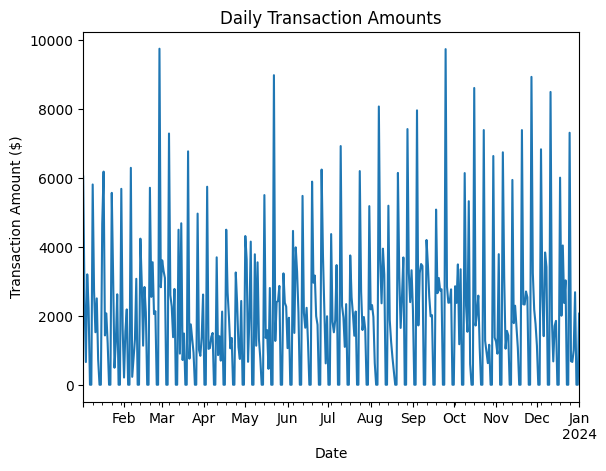

In [8]:
# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

# Extract temporal features
df['TransactionHour'] = df['TransactionDate'].dt.hour
df['TransactionDay'] = df['TransactionDate'].dt.day
df['TransactionWeekday'] = df['TransactionDate'].dt.weekday  # Monday=0, Sunday=6
df['TransactionMonth'] = df['TransactionDate'].dt.month

# Analyze transaction frequency over time
df.set_index('TransactionDate')['TransactionAmount'].resample('D').sum().plot(title="Daily Transaction Amounts")
# Label the axes with units
plt.xlabel("Date")
plt.ylabel("Transaction Amount ($)")
plt.show()

C:\Users\sghas\AppData\Local\Temp\ipykernel_19916\387779008.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.set_index('TransactionDate')['TransactionAmount'].resample('M').sum()


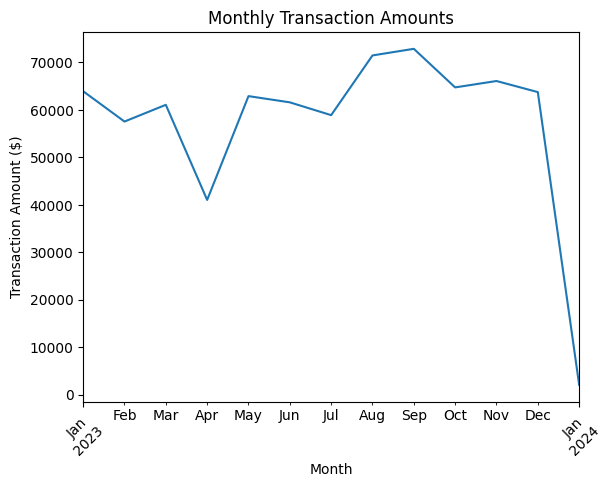

In [10]:
# Resample and plot monthly transaction amounts
monthly_data = df.set_index('TransactionDate')['TransactionAmount'].resample('M').sum()
monthly_data.plot(title="Monthly Transaction Amounts")

# Label the axes with units
plt.xlabel("Month")
plt.ylabel("Transaction Amount ($)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Now, we can do things like:

In [12]:
# Number of transactions per day
transactions_per_day = df.groupby(df['TransactionDate'].dt.date).size()

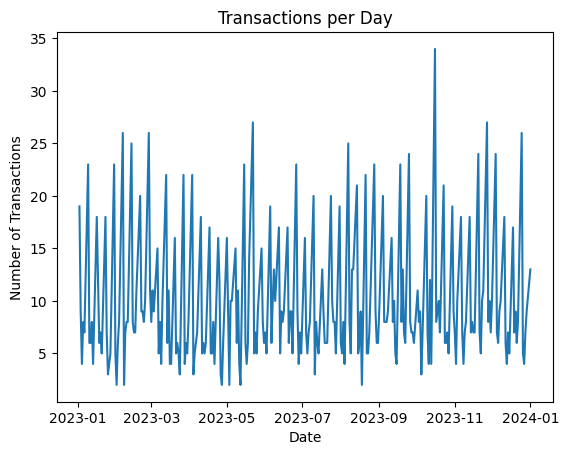

In [13]:
transactions_per_day.plot(kind='line', title='Transactions per Day')
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()


## 1.2. Data Cleaning
### 1.2.1 Checking missing values

In [14]:
# Total missing values per column
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
TransactionHour            0
TransactionDay             0
TransactionMonth           0
TransactionWeekday         0
dtype: int64


### 1.2.2.  Detect and Handle Outliers

In [15]:
from scipy import stats

# Z-score method
z_scores = np.abs(stats.zscore(df[['TransactionAmount']]))
df = df[(z_scores < 3).all(axis=1)]  # keep rows within 3 standard deviations

# Alternatively: IQR method
Q1 = df['TransactionAmount'].quantile(0.25)
Q3 = df['TransactionAmount'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['TransactionAmount'] >= Q1 - 1.5*IQR) & (df['TransactionAmount'] <= Q3 + 1.5*IQR)]


### 1.2.3. Handle Data Types
Some of our columns are stored as object, meaning they may need conversion for analysis.

In [16]:
# Label Encoding for simple ordinal modeling
for col in ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

TransactionID is just a unique row ID. No meaningful signal for patterns so we drop it from our dataset.

In [18]:
df = df.drop(columns=['TransactionID'])

AccountID, DeviceID, IP Address and MerchantID can help detect anomalies like fraud, spoofing, or account takeovers.

In [19]:
# Encode them numerically
df['AccountID'] = LabelEncoder().fit_transform(df['AccountID'])
df['DeviceID'] = LabelEncoder().fit_transform(df['DeviceID'])
df['IP Address'] = LabelEncoder().fit_transform(df['IP Address'])
df['MerchantID'] = LabelEncoder().fit_transform(df['MerchantID'])


## 1.3 Time-Based Transformations
### 1.3.1. Normalize Data Temporally
Resample (e.g., daily or weekly aggregates):

In [21]:
df.set_index('TransactionDate', inplace=True)

# Daily transaction volume
daily_txn = df.resample('D').size()

# Weekly average amount
weekly_avg_amount = df['TransactionAmount'].resample('W').mean()


### 1.3.2 Smoothing (Rolling averages)

In [22]:
rolling_txn = daily_txn.rolling(window=7).mean()


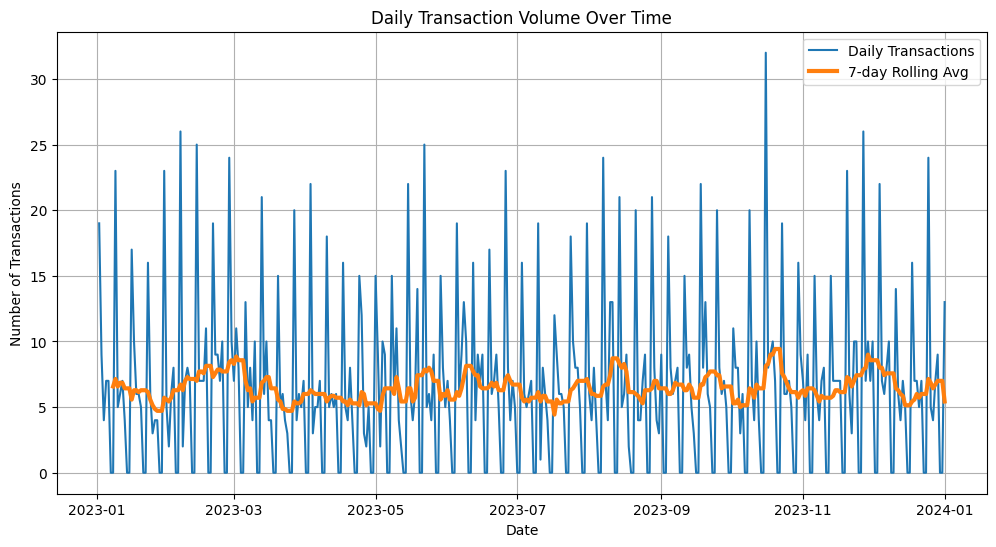

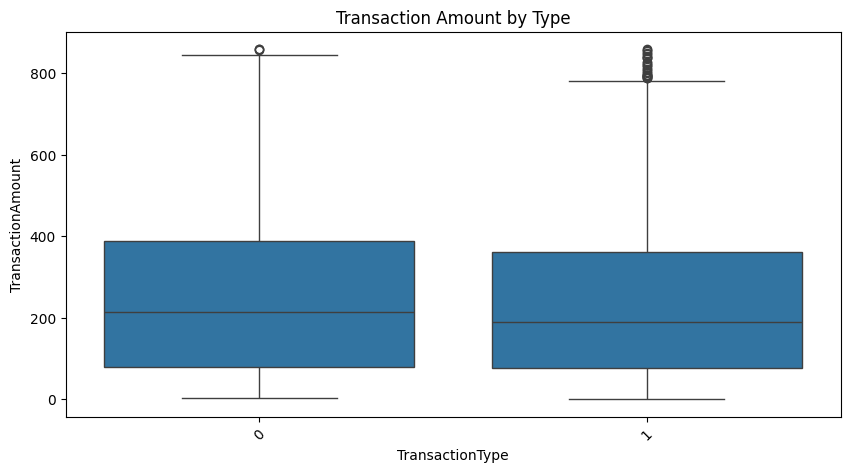

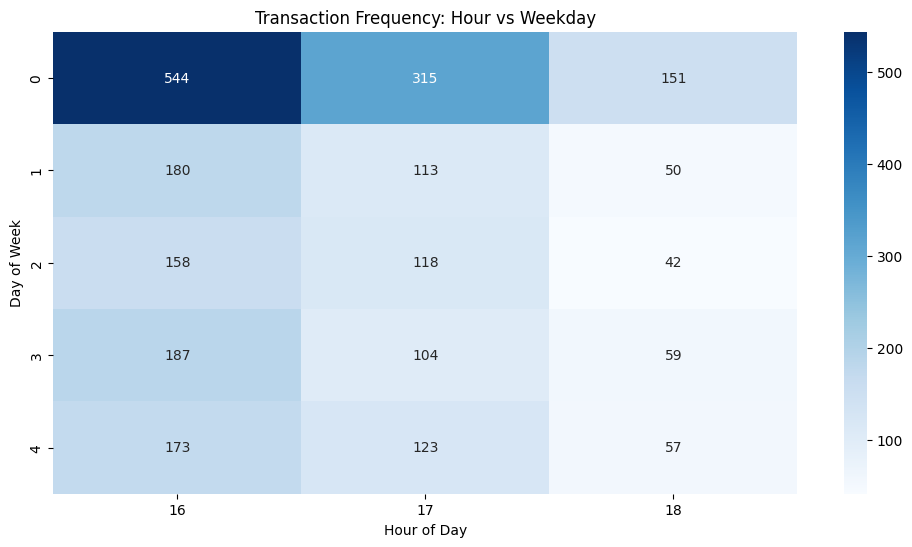

In [23]:
# Trend in daily transactions
plt.figure(figsize=(12,6))
plt.plot(daily_txn, label='Daily Transactions')
plt.plot(rolling_txn, label='7-day Rolling Avg', linewidth=3)
plt.title('Daily Transaction Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)
plt.show()

# Boxplot to reveal outliers
plt.figure(figsize=(10,5))
sns.boxplot(x='TransactionType', y='TransactionAmount', data=df)
plt.title('Transaction Amount by Type')
plt.xticks(rotation=45)
plt.show()

# Heatmap of transaction count by hour and weekday
pivot = df.groupby(['TransactionWeekday', 'TransactionHour']).size().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='Blues', annot=True, fmt='d')
plt.title('Transaction Frequency: Hour vs Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()
